## 1. Data Preparation and Exploration

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

# Load data
final_db = pd.read_csv('../01_data/discrimination_data.csv')

/var/folders/rc/lkcpnkds55926rr708hlfnwr0000gn/T/ipykernel_90858/161896255.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=percentages.index, y=percentages.values, palette='viridis')


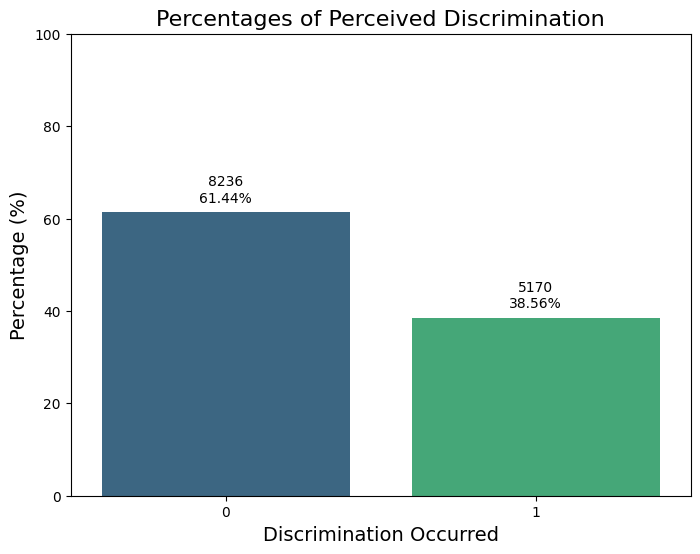

In [7]:
# Calculate the value counts
value_counts = final_db['discrimination_occurred'].value_counts()

# Calculate the percentages
percentages = value_counts / final_db.shape[0] * 100

# Round the percentages to 2 decimal places
percentages = percentages.round(2)

# Create the bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=percentages.index, y=percentages.values, palette='viridis')

# Add titles and labels
plt.title('Percentages of Perceived Discrimination', fontsize=16)
plt.xlabel('Discrimination Occurred', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)

# Add total count and percentage labels at the center of the bars
for i, p in enumerate(ax.patches):
    ax.annotate(f'{value_counts[i]}\n{percentages[i]:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points', rotation=0)

# Set y-axis limits to be from 0 to 100
plt.ylim(0, 100)

# Save the image
output_dir = "../04_graphs"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "perceived_discrimination.png")
plt.savefig(output_path, dpi=300)   

# Show the plot
plt.show()

In [3]:
final_db.head()


,discrimination_occurred,respodent_id,interview_country,age,gender,job_situation,ethnic_group,household_income,income_imputed,religion,...,insurance_coverage,violence_exp_by_family,aware_of_support_org,friends_from_diff_ethnicity,friends_from_majority,neighbour_ethnicity,social_transfers,poverty_risk,citizenship_status,stopped_by_police
0,1,165.0,1.0,37.0,1.0,1.0,8.0,15.0,0.0,0.0,...,1,1,0,1,1,0,2,1.0,0.0,1
1,0,317.0,1.0,30.0,1.0,1.0,8.0,19.0,0.0,2.0,...,1,1,1,0,1,1,3,0.0,0.0,1
2,0,321.0,1.0,35.0,1.0,1.0,8.0,17.0,0.0,0.0,...,1,0,1,1,1,0,0,0.0,0.0,1
3,1,322.0,1.0,42.0,1.0,4.0,8.0,14.0,0.0,2.0,...,1,2,1,1,1,0,2,1.0,0.0,1
4,0,327.0,1.0,39.0,1.0,5.0,8.0,10.0,0.0,1.0,...,1,0,0,1,0,0,0,1.0,0.0,1


In [4]:
# Split data
X = final_db.drop(['discrimination_occurred'], axis=1)
y = final_db['discrimination_occurred']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 2. Model Building and Evaluation

###  5-fold Cross Validation

Accuracy for Random Forest: 0.7257583291894579
Random Forest Cross-Validation Accuracy: 0.7223994192974545


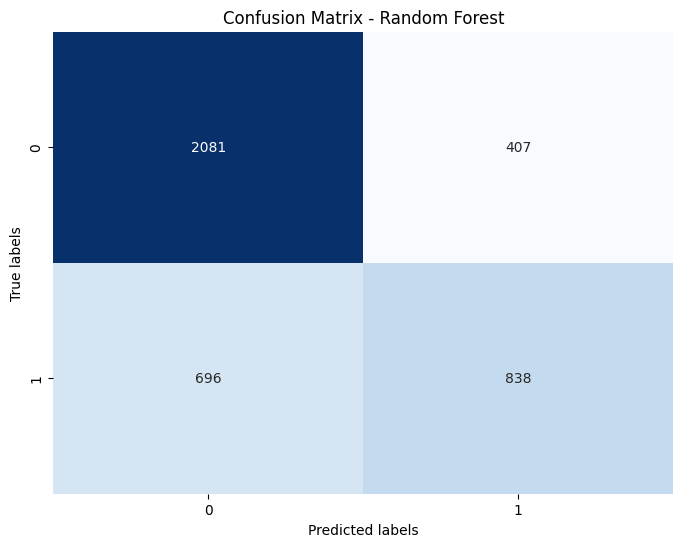

Accuracy for Logistic Regression: 0.7090999502734958
Logistic Regression Cross-Validation Accuracy: 0.7049225673141258


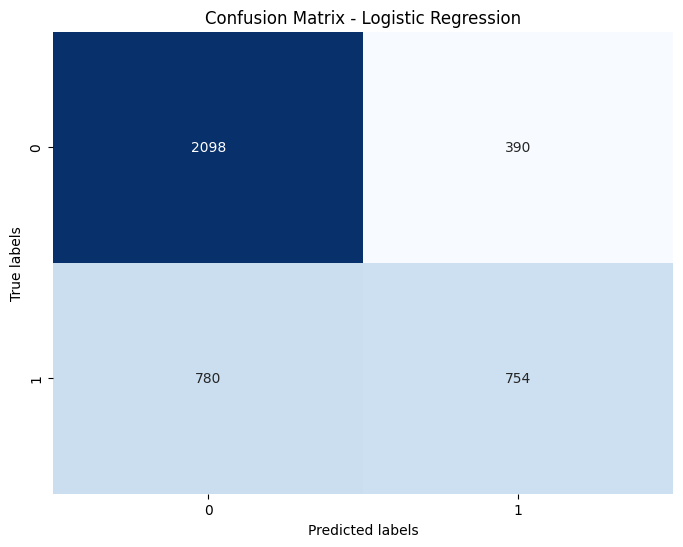

Accuracy for XGBoost: 0.7140726006961711
XGBoost Cross-Validation Accuracy: 0.7125948384267868


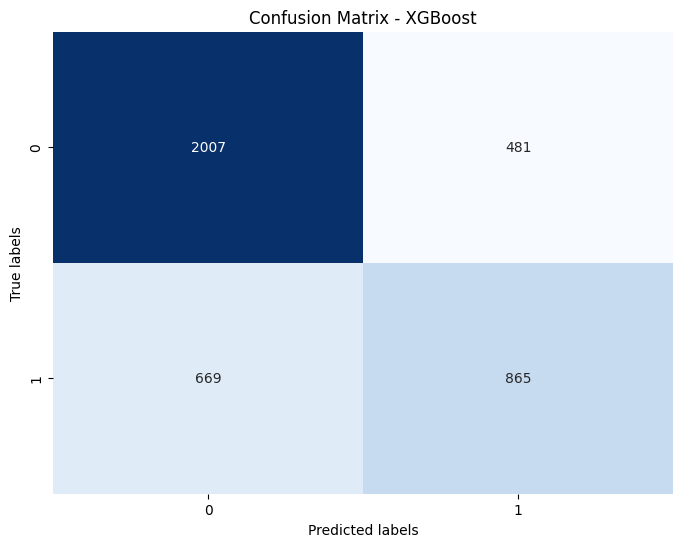

In [8]:
# Define preprocessing steps
preprocessor = StandardScaler()

# Define models
rf = RandomForestClassifier(random_state=42)
lr = LogisticRegression(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Create pipelines for each model
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf)])
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lr)])
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgb)])

# Train and evaluate models
models = [rf_pipeline, lr_pipeline, xgb_pipeline]
model_names = ['Random Forest', 'Logistic Regression', 'XGBoost']

for model, name in zip(models, model_names):
    # Train model
    model.fit(X_train, y_train)
    
    # Evaluate model
    accuracy = model.score(X_test, y_test)
    print(f"Accuracy for {name}: {accuracy}")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{name} Cross-Validation Accuracy: {cv_scores.mean()}")
    
    # Confusion Matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {name}')

    # Save the image
    output_path = os.path.join(output_dir, f'confusion_matrix_{name.replace(" ", "_").lower()}.png')
    plt.savefig(output_path, dpi=300)   
    
    # Show the plot
    plt.show()

### 10-fold Cross Validation


Accuracy for Random Forest: 0.7257583291894579
Random Forest Cross-Validation Accuracy: 0.7219753582611815


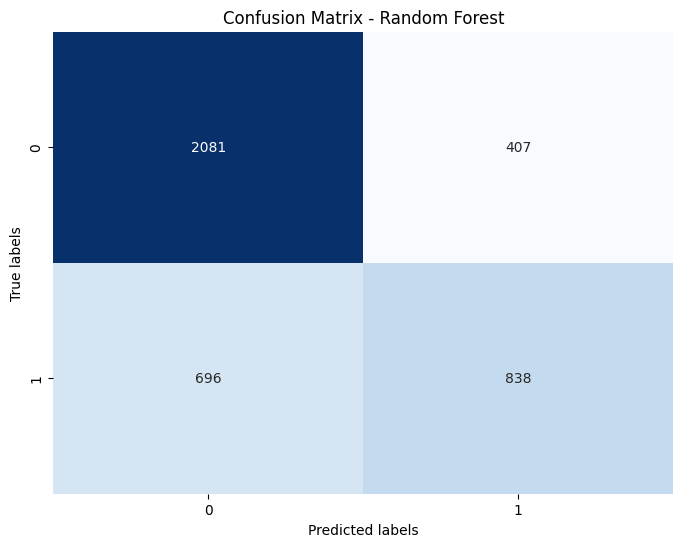

Accuracy for Logistic Regression: 0.7090999502734958
Logistic Regression Cross-Validation Accuracy: 0.7056701885370046


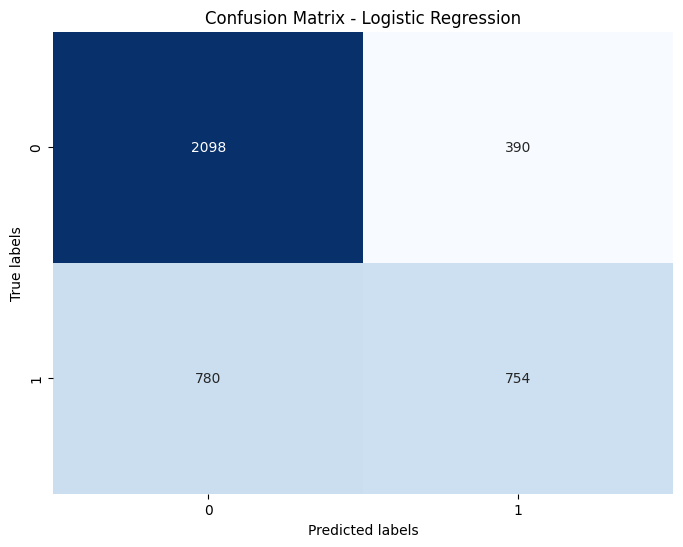

Accuracy for XGBoost: 0.7140726006961711
XGBoost Cross-Validation Accuracy: 0.7186718166356715


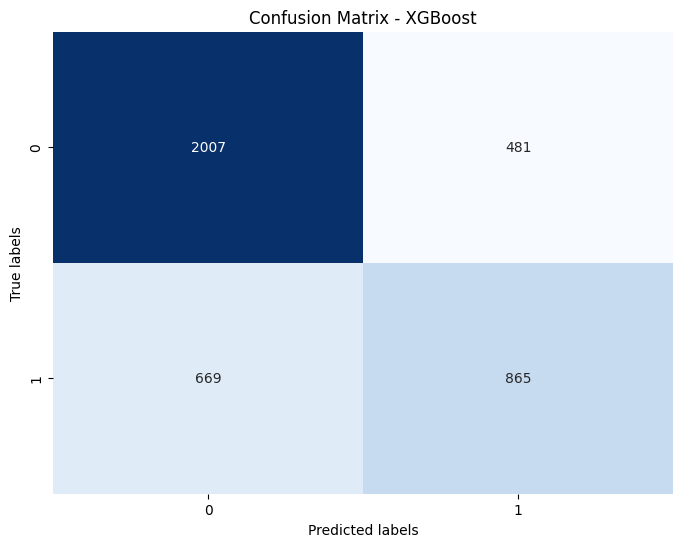

In [9]:
# Define preprocessing steps
preprocessor = StandardScaler()

# Define models
rf = RandomForestClassifier(random_state=42)
lr = LogisticRegression(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Create pipelines for each model
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf)])
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lr)])
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgb)])

# Train and evaluate models
models = [rf_pipeline, lr_pipeline, xgb_pipeline]
model_names = ['Random Forest', 'Logistic Regression', 'XGBoost']

for model, name in zip(models, model_names):
    # Train model
    model.fit(X_train, y_train)
    
    # Evaluate model
    accuracy = model.score(X_test, y_test)
    print(f"Accuracy for {name}: {accuracy}")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=10)
    print(f"{name} Cross-Validation Accuracy: {cv_scores.mean()}")
    
    # Confusion Matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {name}')
    
    # Show the plot
    plt.show()

In [8]:
for model, name in zip(models, model_names):
    # Train model
    model.fit(X_train, y_train)
    
    # Evaluate model
    accuracy = model.score(X_test, y_test)
    print(f"Accuracy for {name}: {accuracy:.2f}")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{name} 5-Fold Cross-Validation Accuracy: {cv_scores.mean():.2f}")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=10)
    print(f"{name} 10-Fold Cross-Validation Accuracy: {cv_scores.mean():.2f}")

    # Confusion Matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {name}:\n{cm}\n")

Accuracy for Random Forest: 0.73
Random Forest 5-Fold Cross-Validation Accuracy: 0.72
Random Forest 10-Fold Cross-Validation Accuracy: 0.72
Confusion Matrix for Random Forest:
[[2081  407]
 [ 696  838]]

Accuracy for Logistic Regression: 0.71
Logistic Regression 5-Fold Cross-Validation Accuracy: 0.70
Logistic Regression 10-Fold Cross-Validation Accuracy: 0.71
Confusion Matrix for Logistic Regression:
[[2098  390]
 [ 780  754]]

Accuracy for XGBoost: 0.71
XGBoost 5-Fold Cross-Validation Accuracy: 0.71
XGBoost 10-Fold Cross-Validation Accuracy: 0.72
Confusion Matrix for XGBoost:
[[2007  481]
 [ 669  865]]



AUC for Random Forest: 0.7807
AUC for Logistic Regression: 0.7570
AUC for XGBoost: 0.7626


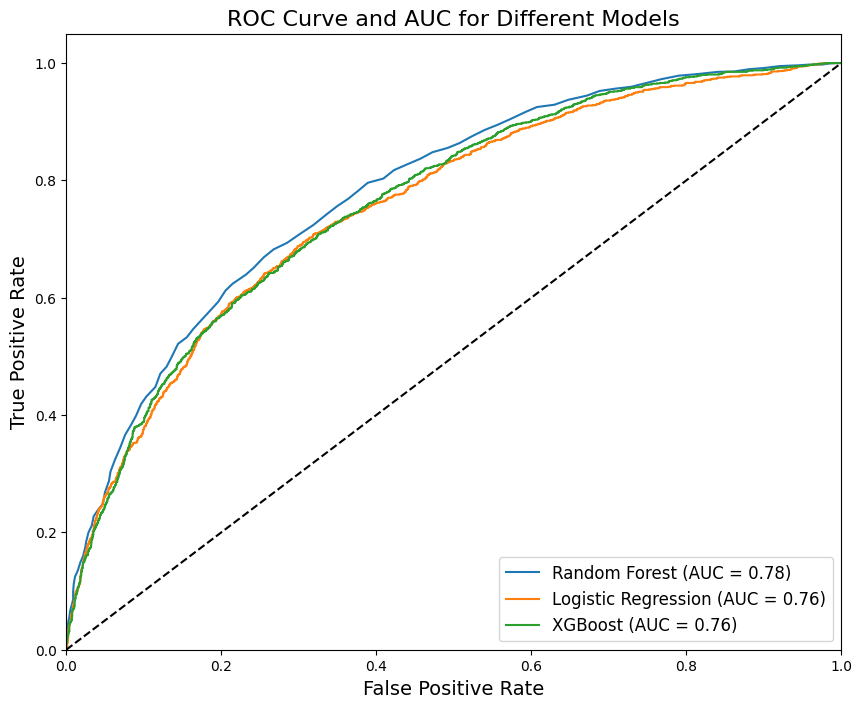

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define models
models = [rf_pipeline, lr_pipeline, xgb_pipeline]
model_names = ['Random Forest', 'Logistic Regression', 'XGBoost']

plt.figure(figsize=(10, 8))

for model, name in zip(models, model_names):
    # Get the predicted probabilities
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Print AUC values
    print(f'AUC for {name}: {roc_auc:.4f}')
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--')

# Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve and AUC for Different Models', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error

# Predict probabilities on the test set using the Random Forest model
y_pred_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Calculate the Mean Squared Error
mse_rf = mean_squared_error(y_test, y_pred_prob_rf)
print(f"Mean Squared Error for Random Forest: {mse_rf:.4f}")

# Predict probabilities on the test set using Logistic Regression model
y_pred_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]
mse_lr = mean_squared_error(y_test, y_pred_prob_lr)
print(f"Mean Squared Error for Logistic Regression: {mse_lr:.4f}")

# Predict probabilities on the test set using XGBoost model
y_pred_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]
mse_xgb = mean_squared_error(y_test, y_pred_prob_xgb)
print(f"Mean Squared Error for XGBoost: {mse_xgb:.4f}")

Mean Squared Error for Random Forest: 0.1822
Mean Squared Error for Logistic Regression: 0.1910
Mean Squared Error for XGBoost: 0.1966


## Feature Importance and Hyperparameter Tuning

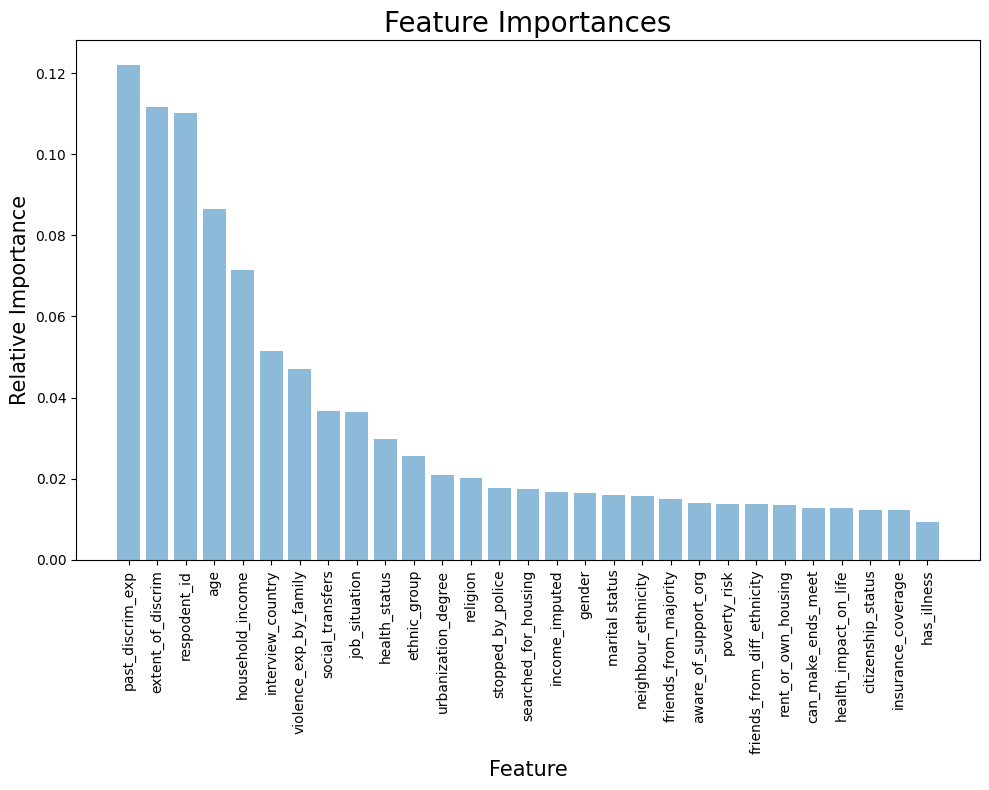

In [16]:
# Feature Importance
feature_importances = rf.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title('Feature Importances', fontsize=20)
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center', alpha=0.5)
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
plt.ylabel('Relative Importance', fontsize=15)
plt.xlabel('Feature', fontsize=15)
plt.tight_layout()


# Save the plot in the specified folder as a PNG
file_path = os.path.join(output_dir, 'feature_importance.png')
plt.savefig(file_path, dpi=300)   

plt.show()

In [13]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV to find the best parameters
cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
cv_rf.fit(X_train_scaled, y_train)

# Print the best parameters found by GridSearchCV
best_params = cv_rf.best_params_
print("Best parameters:", best_params)

# The model is already refitted with the best parameters, so we can directly use it for evaluation
# Evaluate the model with best parameters
best_rf_score = cv_rf.score(X_test_scaled, y_test)
print("Accuracy with best parameters:", best_rf_score)


Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy with best parameters: 0.7257583291894579


In [15]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV to find the best parameters
cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
cv_rf.fit(X_train_scaled, y_train)

# Print the best parameters found by GridSearchCV
best_params = cv_rf.best_params_
print("Best parameters:", best_params)

# The model is already refitted with the best parameters, so we can directly use it for evaluation
# Evaluate the model with best parameters
best_rf_score = cv_rf.score(X_test_scaled, y_test)
print("Accuracy with best parameters:", best_rf_score)


Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy with best parameters: 0.7257583291894579


In [12]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# GridSearchCV to find the best parameters
cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
cv_rf.fit(X_train_scaled, y_train)

best_params = cv_rf.best_params_
print("Best parameters:", best_params)

# Retrain the model with the best parameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_scaled, y_train)

# Evaluate the model
best_rf_score = best_rf.score(X_test_scaled, y_test)
print("Accuracy with best parameters:", best_rf_score)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Accuracy with best parameters: 0.7297364495275982
